## Loading the Inception model from the [Applications of Keras](https://keras.io/applications/) or [Transfer learning with a pretrained ConvNet](https://www.tensorflow.org/tutorials/images/transfer_learning)
Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.

Weights are downloaded automatically when instantiating a model.

## (a) The Ising Model – try your show that the square lattice data can be trained perfectly using the embeddings of Inception.

Get the embeddings first, then build a classifier

Solution to (a):

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jit, vmap

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras

import sklearn
from sklearn.model_selection import train_test_split

#import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import optimizers

KeyboardInterrupt: 

In [ ]:
# make sure 
#tf.compat.v2.enable_eager_execution()

In [ ]:
# Import the data and shape it for training
with tf.device('/CPU:0'):

    N = 250
    nx, ny = 32, 32

    Xsq = np.ndarray((4*N,nx,ny,1))
    ysq = np.ndarray(4*N)

    for i in np.arange(N):
        Xsq[i + 0*N] = np.loadtxt("./square_T1/square_T1/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
        ysq[i + 0*N] = 0
        Xsq[i + 1*N] = np.loadtxt("./square_T2/square_T2/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
        ysq[i + 1*N] = 1
        Xsq[i + 2*N] = np.loadtxt("./square_T3/square_T3/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
        ysq[i + 2*N] = 2
        Xsq[i + 3*N] = np.loadtxt("./square_T4/square_T4/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
        ysq[i + 3*N] = 3
    
    # create train/test splits
    Xsq_train, Xsq_test, ysq_train, ysq_test = train_test_split(Xsq, ysq, test_size=0.2, random_state=0)
    
    # Reshape the data for input into transfer model
    Xsq_train, Xsq_test = np.repeat(Xsq_train, 8, 1), np.repeat(Xsq_test, 8, 1)
    Xsq_train, Xsq_test = np.repeat(Xsq_train, 8, 2), np.repeat(Xsq_test, 8, 2)
    Xsq_train, Xsq_test = np.repeat(Xsq_train, 3, 3), np.repeat(Xsq_test, 3, 3)
    #Xsq_train, Xsq_test = tf.cast(Xsq_train, tf.float32), tf.cast(Xsq_test, tf.float32)

In [ ]:
# Get the inception model without last layer and disable training
with tf.device('/CPU:0'):
    base_model = keras.applications.inception_v3.InceptionV3(include_top=False, 
                                                            weights='imagenet', 
                                                            input_shape=Xsq_train[0].shape
                                                            )

    base_model.trainable = False

In [ ]:
# Get the embedded data and normalize
global_avg_layer = keras.layers.GlobalAveragePooling2D()
Xsq_train_emb, Xsq_test_emb = global_avg_layer(base_model.predict(Xsq_train)), global_avg_layer(base_model.predict(Xsq_test))
Xsq_train_emb, Xsq_test_emb = Xsq_train_emb.numpy()/Xsq_train_emb.numpy().max(), Xsq_test_emb.numpy()/Xsq_test_emb.numpy().max()

In [ ]:
Xsq_train_emb

In [ ]:
class classify_FNN:
    def __init__(self):
        model = self
    
    @staticmethod
    def build(num_classes, channels_first=False):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Dense(32, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
        
        return model
    
    def get_layers():
        layers = [
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
        ]
        return layers

In [ ]:
def train_classify_layers(model_class, train_data, train_lbls, test_data, test_lbls, 
                          num_classes, input_shape, hyperparams):
    x_train = train_data
    x_test = test_data
    
    # Create categorical labels
    y_train = keras.utils.to_categorical(train_lbls, num_classes)
    y_test = keras.utils.to_categorical(test_lbls, num_classes)
    
    # Instantiate the model
    model = model_class.build(num_classes=num_classes)
    
    # Set hyperparameters
    INIT_LR = FNN_hyperparams[0]# learning rate
    EPOCHS = FNN_hyperparams[1] # number of epochs
    BS = FNN_hyperparams[2] # batch size
    OPT = tf.keras.optimizers.Adagrad(lr=INIT_LR) # optimizing function
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])
    
    # Train the model
    H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=EPOCHS,
                  batch_size=BS)
    
    return H, model

In [ ]:
# hyperparams should be a tuple of: INIT_LR, EPOCHS, BS
FNN_hyperparams = (0.01, 50, 32)
H_sq_FNN, sq_FNN_model = train_classify_layers(classify_FNN, Xsq_train_emb, ysq_train,
                                     Xsq_test_emb, ysq_test, 4, 2048, FNN_hyperparams)

## (b)  [Rayleigh-Bénard Convection](https://en.wikipedia.org/wiki/Rayleigh%E2%80%93B%C3%A9nard_convection)

RB convection, in which a flow is heated from below and cooled  from  top,  is  one  of  the  paradigmatic  system  in  fluid  dynamics. When the temperature difference between the two plates (in dimensionless form Rayleigh number Ra) is beyond certain threshold, hot fluid tends to go up and cold fluid tends to go down, thus forming convection cells. What we supply here are the temperature snapshots from four different Ra, i.e., $Ra=10^{14}$ as `class0`,$Ra= 10^{13}$ as `class1`, $Ra= 10^{12}$ as `class2`,and $Ra= 10^{11}$ as `class3`.  The flow you see is highly turbulent; not only there are big convection cells but also lots of small vortices.  The original dataset  is  around  4000*2000.   We  have  already  downsampled  the  data into the zip file `fluid_org.zip`.

### (1) Train the data in `fluid_org.zip` with inception.  Show that these images can be classified  into  different $Ra$ nicely  with  inception.  

Take the length 2048 embeddings from the Inception model first. Then visualizing how the embeddings distribute using a two component PCA or two component T-SNE, whichever you prefer. Then use any of the previously learned method to train a classifier using the embeddings as input. **Note that T-SNE normally gives you better separation**

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jit, vmap

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import optimizers

Using TensorFlow backend.


In [2]:
import os
from PIL import Image

with tf.device('/CPU:0'):
    imgs = []
    lbls = []
    for file in os.listdir('./fluid_org/fluid_org/'):
        imgs.append(np.array(Image.open('./fluid_org/fluid_org/'+file))/255)
        lbls.append(int(file[-5]))

In [3]:
with tf.device('/CPU:0'):
    imgs = np.array(imgs)
    lbls = np.array(lbls)

In [4]:
imgs.shape

(751, 250, 500, 3)

Solution to (1):

In [5]:
with tf.device('/CPU:0'):
    base_model_2 = keras.applications.inception_v3.InceptionV3(include_top=False, 
                                                            weights='imagenet', 
                                                            input_shape=imgs[0].shape
                                                            )

    base_model_2.trainable = False

In [6]:
global_avg_layer = keras.layers.GlobalAveragePooling2D()
imgs_emb = global_avg_layer(base_model_2.predict(imgs))
imgs_emb = imgs_emb.numpy()/imgs_emb.numpy().max()

In [7]:
imgs_emb.shape

(751, 2048)

In [8]:
tsne = TSNE(n_components=2)

In [9]:
tsne_img_emb = tsne.fit_transform(imgs_emb)

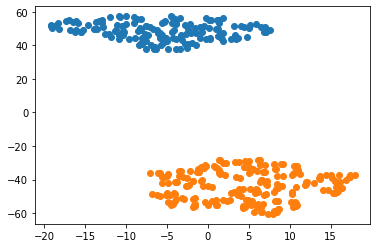

In [10]:
for i in range(2):
    plt.plot(tsne_img_emb.transpose()[0][lbls==i],tsne_img_emb.transpose()[1][lbls==i],'.',markersize=12)

### (2) For advanced use of trainsfer learning from the pre-trained models such as fine-tuning, we need to do the transfer learning in-place, by building a network consists of the Inception and your classifier layers. 
Freeze the part you take from Inception, train
the model and report the accuracy. Then do the fine-tuning. Report
how much increase of accuracy you can manage to get. Fine tuning
by making the top few layer of the Inception model trainable instead
of freezing all the layers. Due to the slowness of training, unleash the
layers one by one. Make comments about how the accuracy change. It is
highly recommended that you train this on Google Colab with the GPU
activated.

Solution to (2):

In [17]:
def train_model_2(model, train_data, train_lbls, test_data, 
                test_lbls, num_classes, input_shape, hyperparams):
    # Ensure data is shaped properly, assumes channels last set up
    x_train = train_data
    x_test = test_data.reshape((test_data.shape[0],) + input_shape).astype("float32")
    
    # Create categorical labels
    y_train = keras.utils.to_categorical(train_lbls, num_classes)
    y_test = keras.utils.to_categorical(test_lbls, num_classes)
    
    # Set hyperparameters
    INIT_LR = hyperparams[0]# learning rate
    EPOCHS = hyperparams[1] # number of epochs
    BS = hyperparams[2] # batch size
    OPT = tf.keras.optimizers.Adagrad(lr=INIT_LR) # optimizing function
    
    # Compile the model
    model.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=['accuracy'])
    
    
    H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=EPOCHS,
                  batch_size=BS)
    
    return H, model

In [18]:
class classify_FNN:
    def __init__(self):
        model = self
    
    @staticmethod
    def build(num_classes, channels_first=False):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Dense(32, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
        
        return model
    
    def get_layers(num_classes):
        layers = [
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
        ]
        return layers

In [19]:
# Create the full model
with tf.device('/CPU:0'):
    layer_list = [base_model_2, global_avg_layer]+classify_FNN.get_layers(4)
    model = tf.keras.Sequential(layer_list)

In [20]:
# Look at the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 14, 2048)       21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_95 (Batc (None, 32)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [21]:
# Create train/test splits
train_imgs, test_imgs, train_lbls, test_lbls = train_test_split(imgs, lbls, test_size=0.2, random_state=0)

In [22]:
hyperparams = (0.01, 50, 64)
H, trained_model = train_model_2(model, train_imgs, train_lbls, test_imgs, test_lbls, 4, (250, 500, 3), hyperparams)

Train on 600 samples, validate on 151 samples
Epoch 1/50
600/600 [==============================] - 15s 25ms/sample - loss: 0.7923 - accuracy: 0.6967 - val_loss: 1.3530 - val_accuracy: 0.3245
Epoch 2/50
600/600 [==============================] - 6s 11ms/sample - loss: 0.2541 - accuracy: 0.9333 - val_loss: 1.5245 - val_accuracy: 0.2980
Epoch 3/50
600/600 [==============================] - 6s 10ms/sample - loss: 0.1466 - accuracy: 0.9783 - val_loss: 1.3264 - val_accuracy: 0.4371
Epoch 4/50
576/600 [===========================>..] - ETA: 0s - loss: 0.1310 - accuracy: 0.9785

KeyboardInterrupt: 

### (3) Explore the potential of transfer learning on cropped data `fluid-crop`, which are randomly choosen regions of 100*100 pixels from each original 4000*2000 pictures, i.e.,just around 1% of the original picture! 
You can use either method you use in (1) or (2).

Solution to (3):

### (4) Build your own classifier for (2) and (3) without using Inception. Compare the performance of your own classifier with the result in (2) and (3)

Solution to (4):

### (5) Continue (3), construct two examples where a different layer's output is used as the embedding. There are over 300 layers in Inception. Pick one at around the 100th layer and one at around 200th layer. The exact layer you pick is based on your preference. Show the following.
- (i) The distributions of the embeddings similar to what you've done in (1). Together with the result you get in (1), comment the similarity and difference between what you get using the three embedding layers.
- (ii) What is the test accuracy of the three classifiers. What is the test accuracy of the three classifiers? For speeding up the training you can choose to get the embeddings first and put those into a classifier, as you did in (1).

Solution to (5):